In [107]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
import glob
from pathlib import Path

## Number of neighbors

Check how the result of the manifold sculpting depends on the number of neighbors used. Compare with other popular algorithms.

In [108]:
data_folder = Path('../data/results/neighbors/')
figures_folder = Path('../figs/SwissRoll/')
dataset2d_path = Path('../data/datasets/2d/N_2000.npy')

save_figures = True

if not data_folder.exists():
    raise FileNotFoundError(f"Data folder {data_folder} does not exist. Please provide a valid dataset path.")

if save_figures:
    figures_folder.mkdir(parents=True, exist_ok=True)

if not dataset2d_path.exists():
    raise FileNotFoundError(f"Dataset 2D file {dataset2d_path} does not exist. Please provide a valid dataset path.")

n_neighbors = [20, 28, 40, 57, 80]

isomap_paths = {n_neighbors[i]: file for i, file in enumerate(sorted(data_folder.glob('Isomap_[0-9][0-9].npy'), key=lambda x: int(x.stem.split('_')[1])))}
lle_paths = {n_neighbors[i]: file for i, file in enumerate(sorted(data_folder.glob('LLE_[0-9][0-9].npy'), key=lambda x: int(x.stem.split('_')[1])))}
ms_paths = {n_neighbors[i]: file for i, file in enumerate(sorted(data_folder.glob('MS_[0-9][0-9].npy'), key=lambda x: int(x.stem.split('_')[1])))}

times_files = list(data_folder.glob('*_time.npy'))
time_key = lambda x: str(x.stem.split('_')[0])
times_files = {time_key(file): file for file in times_files if time_key(file) in file.name}

In [109]:
isomap_files = {}
lle_files = {}
ms_files = {}

for n in n_neighbors:
    isomap_files[n] = np.loadtxt(isomap_paths[n])
    lle_files[n] = np.loadtxt(lle_paths[n])
    ms_files[n] = np.loadtxt(ms_paths[n])

### Time comparison

Check how much time is required to complete the calculation.

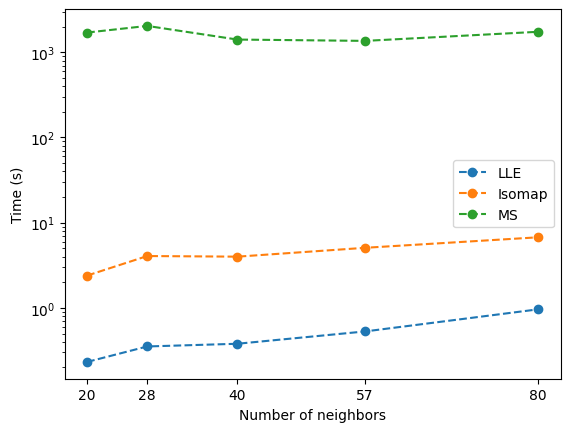

In [110]:
for key in list(times_files.keys()):
    data = np.loadtxt(times_files[key])
    plt.semilogy(n_neighbors, data, label=key, marker='o', linestyle='--')

plt.xlabel('Number of neighbors')
plt.ylabel('Time (s)')
plt.xticks(n_neighbors)
plt.legend()
plt.show()

In [111]:
def pca(data):
    covariance_matrix = np.cov(data, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    
    return sorted_eigenvalues, sorted_eigenvectors

ms_keys = sorted(ms_files.keys())
rotated_dataset = {}
for key in ms_keys:
    X_ms = ms_files[key]

    X_ms -= np.mean(X_ms, axis=0)
    eigenvals, eigenvecs = pca(X_ms)
    axis_point = np.array([0, 0, 0])
    axis_direction = np.array([0, 0, 1])
    theta = 0

    rotation_matrix = np.eye(3)
    rotation_matrix[:, :2] = eigenvecs[:, :2]

    # Rotate the data
    rotated_dataset[key] = X_ms @ rotation_matrix

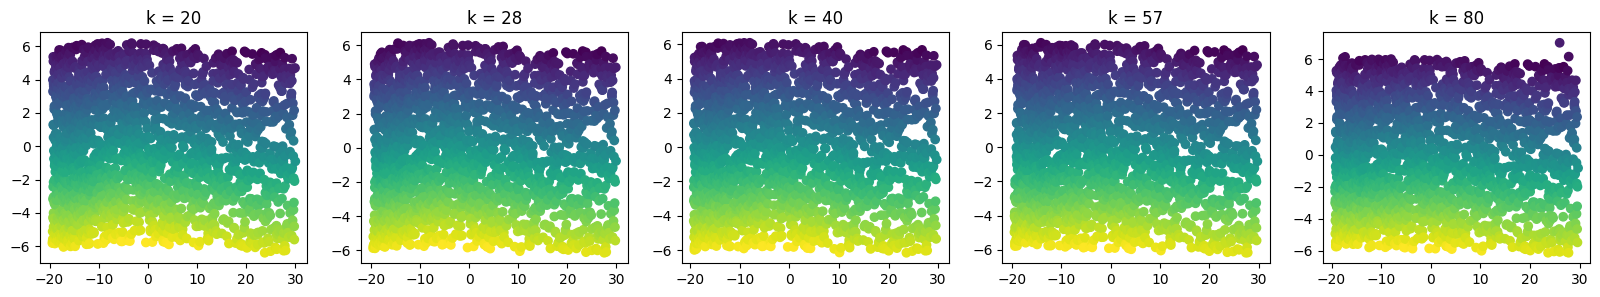

In [112]:
# Plotting the rotated datasets for each number of neighbors
fig, axs = plt.subplots(1, 5, figsize=(20, 3))

for i, key in enumerate(ms_keys):
    X_ms = rotated_dataset[key]
    if i == 1:
        X_ms[:, 0] = X_ms[:, 0] * -1
    if i == 3:
        X_ms[:, 1] = X_ms[:, 1] * -1
    axs[i].scatter(X_ms[:, 0], X_ms[:, 1], c=X_ms[:, 2], label=f"MS {key}", cmap='viridis')
    axs[i].set_title(f"k = {key}")

In [113]:
mse_isomap = np.zeros(len(isomap_files))
mse_lle = np.zeros(len(lle_files))
mse_ms = np.zeros(len(ms_files))

X_2D_scal = np.load(dataset2d_path)

X_2D_scal = minmax_scale(X_2D_scal)

for i, key in enumerate(n_neighbors):

    X_isomap = isomap_files[key]
    X_lle = lle_files[key]
    X_ms = rotated_dataset[key]

    X_isomap_scal = X_isomap.copy()
    X_lle_scal = X_lle.copy()
    X_ms_scal = X_ms.copy()

    X_isomap_scal[:, 1] *= -1

    if i == 1:
        X_ms[:, 0] *= -1
        X_lle_scal[:, 0] *= -1

    if i == 2:
        X_lle_scal[:, 0] *= -1

    if i == 3:
        X_ms[:, 1] *= -1
        X_lle_scal[:, 1] *= -1
        X_lle_scal[:, 0] *= -1
    
    if i == 4:
        X_lle_scal[:, 1] *= -1
        X_lle_scal[:, 0] *= -1

    X_isomap_scal = minmax_scale(X_isomap_scal)
    X_lle_scal = minmax_scale(X_lle_scal)
    X_ms_scal = minmax_scale(X_ms_scal)

    if save_figures:
        fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

        ax[0, 0].scatter(X_2D_scal[:, 0], X_2D_scal[:, 1])
        ax[0, 0].set_title('Theorethocal')

        ax[0, 1].scatter(X_isomap_scal[:, 0], X_isomap_scal[:, 1])
        ax[0, 1].set_title('Isomap')

        ax[1, 0].scatter(X_lle_scal[:, 0], X_lle_scal[:, 1])
        ax[1, 0].set_title('LLE')

        ax[1, 1].scatter(X_ms_scal[:, 0], X_ms_scal[:, 1])
        ax[1, 1].set_title('MS')

        plt.savefig(figures_folder / f"projection_{str(n_neighbors[i])}.png")
        plt.close()

    mse_isomap[i] = mean_squared_error(X_2D_scal, X_isomap_scal)
    mse_lle[i] = mean_squared_error(X_2D_scal, X_lle_scal)
    mse_ms[i] = mean_squared_error(X_2D_scal, X_ms_scal[:, 0:2])


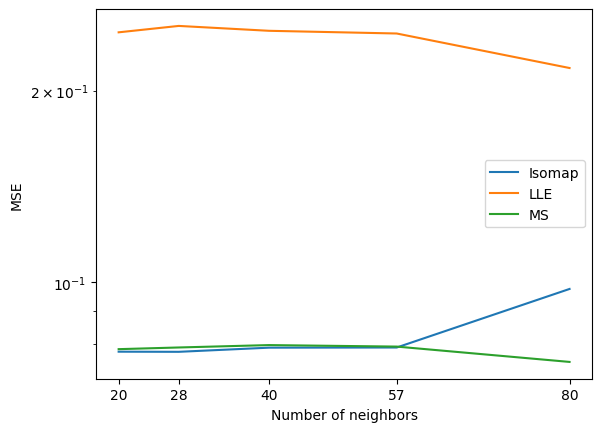

In [114]:
plt.semilogy(n_neighbors, mse_isomap, label='Isomap')
plt.semilogy(n_neighbors, mse_lle, label='LLE')
plt.semilogy(n_neighbors, mse_ms, label='MS')
plt.xticks(n_neighbors)
plt.xlabel('Number of neighbors')
plt.ylabel('MSE')
plt.legend()
if save_figures:
    plt.savefig(figures_folder / 'MSE.png')
plt.show()

In [115]:
del isomap_files, lle_files, ms_files, rotated_dataset

## Sizes

In [116]:
data_folder = Path('../data/results/sizes/')
dataset2d_folder = Path('../data/datasets/2d/')

if not data_folder.exists():
    raise FileNotFoundError(f"Data folder {data_folder} does not exist. Please provide a valid dataset path.")
if not dataset2d_folder.exists():
    raise FileNotFoundError(f"Dataset 2D folder {dataset2d_folder} does not exist. Please provide a valid dataset path.")

isomap_paths = sorted(data_folder.glob('isomap_*.npy'), key=lambda x: int(x.stem.split('_')[1]))
lle_paths = sorted(data_folder.glob('LLE_*.npy'), key=lambda x: int(x.stem.split('_')[1]))
ms_paths = sorted(data_folder.glob('MS_[0-9][0-9]*.npy'), key=lambda x: int(x.stem.split('_')[1]))



X_2D_files = sorted(dataset2d_folder.glob('N_*.npy'), key=lambda x: int(x.stem.split('_')[1]))
if not X_2D_files:
    raise FileNotFoundError(f"No 2D dataset files found in {dataset2d_folder}. Please provide a valid dataset path.")

sizes = [250, 500, 1000]

In [117]:
isomap_files = {}
lle_files = {}
ms_files = {}

for s in sizes:
    isomap_files[s] = np.loadtxt(data_folder / f'isomap_{s}.npy')
    lle_files[s] = np.loadtxt(data_folder / f'LLE_{s}.npy')
    ms_files[s] = np.loadtxt(data_folder / f'MS_{s}.npy')

In [118]:
order = [1, 2, 0]

In [119]:
rotated_dataset = {}
for size in sizes:
    X_ms = ms_files[size]

    X_ms -= np.mean(X_ms, axis=0)
    eigenvals, eigenvecs = pca(X_ms)
    axis_point = np.array([0, 0, 0])
    axis_direction = np.array([0, 0, 1])
    theta = 0

    rotation_matrix = np.eye(3)
    rotation_matrix[:, :2] = eigenvecs[:, :2]

    # Rotate the data
    rotated_dataset[size] = X_ms @ rotation_matrix

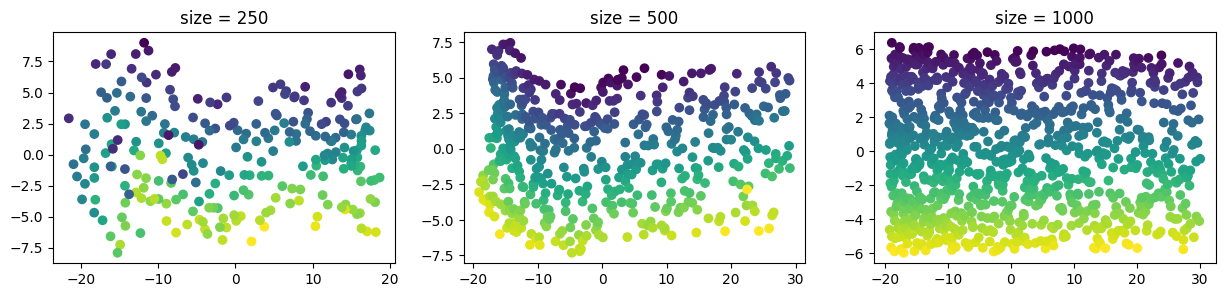

In [120]:
ms_files_rot = sorted(Path(data_folder).glob('MS_rotated_[0-9][0-9]*.npy'), key=lambda x: int(x.stem.split('_')[2]))

fig, axs = plt.subplots(1, 3, figsize=(15, 3))

for i, size in enumerate(sizes):
    X_ms = rotated_dataset[size]
    if i== 2:
        X_ms[:, 0] = X_ms[:, 0] * -1
        X_ms[:, 1] = X_ms[:, 1] * -1
    axs[i].scatter(X_ms[:, 0], X_ms[:, 1], c=X_ms[:, 2], label=f"size = {size}", cmap='viridis')
    axs[i].set_title(f"size = {size}")

In [121]:
mse_isomap = np.zeros(len(isomap_files))
mse_lle = np.zeros(len(lle_files))
mse_ms = np.zeros(len(ms_files))

for i, size in enumerate(sizes):

    X_isomap = isomap_files[size]
    X_lle = lle_files[size]
    X_ms = rotated_dataset[size]

    X_2D_scal = np.load(dataset2d_folder / f"N_{size}.npy")
    X_2D_scal = minmax_scale(X_2D_scal)

    X_isomap_scal = X_isomap
    X_lle_scal = X_lle
    X_ms_scal = X_ms

    X_isomap_scal[:, 1] *= -1

    if i == 0:
        X_ms[:, 0] *= -1

    X_isomap_scal = minmax_scale(X_isomap_scal)
    X_lle_scal = minmax_scale(X_lle_scal)
    X_ms_scal = minmax_scale(X_ms_scal)

    if save_figures:
        fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

        ax[0, 0].scatter(X_2D_scal[:, 0], X_2D_scal[:, 1])
        ax[0, 0].set_title('Theorethocal')

        ax[0, 1].scatter(X_isomap_scal[:, 0], X_isomap_scal[:, 1])
        ax[0, 1].set_title('Isomap')

        ax[1, 0].scatter(X_lle_scal[:, 0], X_lle_scal[:, 1])
        ax[1, 0].set_title('LLE')

        ax[1, 1].scatter(X_ms_scal[:, 0], X_ms_scal[:, 1])
        ax[1, 1].set_title('MS')

        plt.savefig(figures_folder / f"projection_{size}.png")
        plt.close()

    mse_isomap[i] = mean_squared_error(X_2D_scal, X_isomap_scal)
    mse_lle[i] = mean_squared_error(X_2D_scal, X_lle_scal)
    mse_ms[i] = mean_squared_error(X_2D_scal, X_ms_scal[:, 0:2])


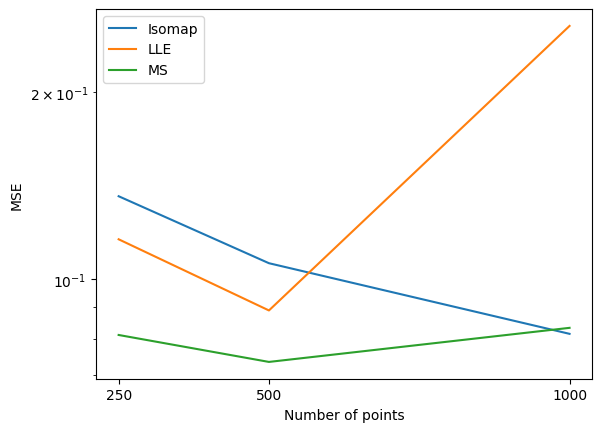

In [122]:
plt.semilogy(sizes, mse_isomap, label='Isomap')
plt.semilogy(sizes, mse_lle, label='LLE')
plt.semilogy(sizes, mse_ms, label='MS')
plt.xticks(sizes)
plt.xlabel('Number of points')
plt.ylabel('MSE')
plt.legend()
# plt.savefig(figures_folder + 'MSE_sizes.png')
plt.show()

In [123]:
del isomap_files, lle_files, ms_files, rotated_dataset, X_2D_scal

# Sigma

In [124]:
data_folder = Path('../data/results/scale_factors/')

if not data_folder.exists():
    raise FileNotFoundError(f"Data folder {data_folder} does not exist. Please provide a valid dataset path.")

dataset2d_path = Path('../data/datasets/2d/N_1000.npy')

if not dataset2d_path.exists():
    raise FileNotFoundError(f"Dataset 2D file {dataset2d_path} does not exist. Please provide a valid dataset path.")

sigmas = [0.80, 0.85, 0.99]

ms_paths = sorted(data_folder.glob('MS_[0-9]*.npy'))

In [125]:
ms_files = {}
for i, sigma in enumerate(sigmas):
    ms_files[sigma] = np.loadtxt(data_folder / f'MS_{i}.npy')

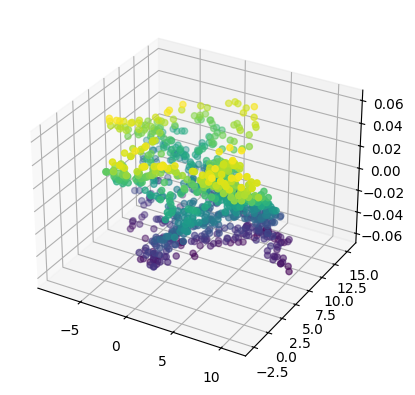

In [126]:
data = ms_files[sigmas[2]]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=data[:, 2])
plt.show()

In [127]:
rotated_dataset = {}

for i, sigma in enumerate(sigmas):
    X_ms = ms_files[sigma]

    X_ms -= np.mean(X_ms, axis=0)
    eigenvals, eigenvecs = pca(X_ms)
    axis_point = np.array([0, 0, 0])
    axis_direction = np.array([0, 0, 1])
    theta = 0

    rotation_matrix = np.eye(3)
    rotation_matrix[:, :2] = eigenvecs[:, :2]

    # Rotate the data
    rotated_dataset[sigma] = X_ms @ rotation_matrix

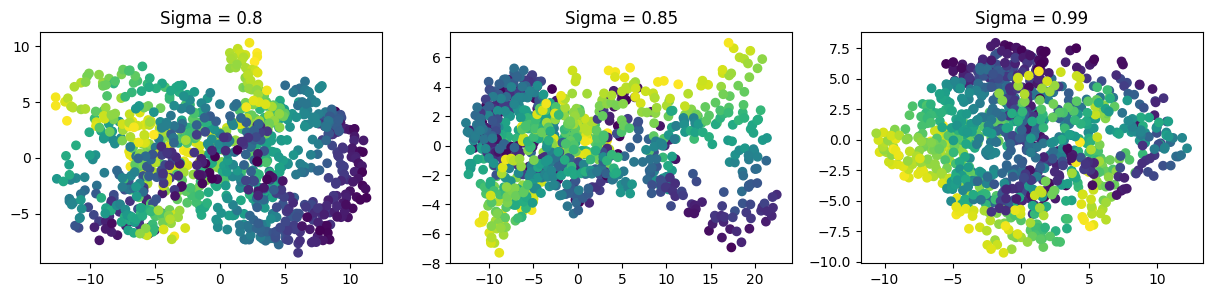

In [128]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3))

for i, sigma in enumerate(sigmas):
    X_ms = rotated_dataset[sigma]
    axs[i].scatter(X_ms[:, 0], X_ms[:, 1], c=X_ms[:, 2], label=str(sigma), cmap='viridis')
    axs[i].set_title(f"Sigma = {sigma}")